# 🔍 LLM Benchmarking with Azure AI and OpenAI
 
This notebook benchmarks various large language models (LLMs) across multiple scenarios.
You can test models deployed via Azure AI Foundry, Azure OpenAI, or directly via OpenAI/GitHub.

## 📦 Step 1: Install Dependencies
Install all required libraries for inference and visualization.

In [17]:
# !pip install -r requirements.txt

## 📁 Step 2: Load Environment Variables
Load all authentication credentials and endpoint URLs from the `.env` file.

In [18]:
import os
from dotenv import load_dotenv
load_dotenv()

True

## 📚 Step 3: Import Libraries
We import inference clients, plotting tools, and utility packages.

In [19]:
from azure.ai.inference import ChatCompletionsClient
from azure.ai.inference.models import SystemMessage, UserMessage
from azure.core.credentials import AzureKeyCredential
from openai import AzureOpenAI, OpenAI
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

## 🔐 Step 4: Set Up Clients
Connect to Azure AI Inference, Azure OpenAI, and OpenAI using your API keys and endpoints.

In [23]:
endpoint1 = os.getenv("AZURE_INFERENCE_SDK_ENDPOINT")
endpoint2 = os.getenv("ENDPOINT_URL")

key = os.getenv("AZURE_INFERENCE_SDK_KEY")
openai_api_key = os.getenv("OPENAI_API_KEY")
deployment = os.getenv("DEPLOYMENT_NAME", "o3-mini")

client1 = ChatCompletionsClient(endpoint=endpoint1, credential=AzureKeyCredential(key))
client2 = AzureOpenAI(azure_endpoint=endpoint2, api_key=key, api_version="2024-12-01-preview")
client3 = OpenAI(api_key=openai_api_key)
client4 = ChatCompletionsClient(endpoint="https://models.inference.ai.azure.com", credential=AzureKeyCredential(os.environ["GITHUB_TOKEN"]))

## 🧠 Step 5: Define Models and Prompts
List the models and define scenarios to evaluate their performance.

In [31]:
# Define models to compare
MODELS = ["DeepSeek-R1","o3-mini","o1-mini"]
    
# Test Prompts for different scenarios
TEST_PROMPTS = {
    "General Q&A": "What is the capital of Canada?",
    "Coding Task": "Write a Python function to check if a number is prime.",
    "Math Problem": "Solve the equation: 2x + 3 = 11",
    "Logical Reasoning": "If all birds can fly and an eagle is a bird, can an eagle fly?",
    "Creative Writing": "Write a short sci-fi story about a robot discovering emotions.",
    "Multi-turn Conversation": "User: Tell me a joke.\nAI: [response]\nUser: Explain why it's funny."
}

## 🧪 Step 6: Define Model Call Functions
Functions to call each model depending on the client they belong to.

In [25]:
def call_azure_foundry(model, prompt):
    try:
        # Create a list of messages for the chat
        messages = [
            SystemMessage(content=f"You are an AI assistant that helps people find information."),
            UserMessage(content=prompt)
        ]
        start_time = time.time()
        # Call the Azure Inference SDK
        response = client1.complete(
            model=model,
            messages=messages
        )
        end_time = time.time()

        response_text = response.choices[0].message.content
        token_usage = response.usage.total_tokens

        # Extract and return the response content
        return response_text.strip(), token_usage, end_time - start_time
    except Exception as e:
        print(f"Error calling model {model}: {e}")
        return None, 0, 0
    
def call_azure_openai(model, prompt):
    try:
        #Prepare the chat prompt 
        chat_prompt = [
            {
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        "text": "You are an AI assistant that helps people find information."
                    }
                ]
            }
        ] 
        # Add user message to the chat prompt
        chat_prompt.append(
            UserMessage(content=prompt)
        )    
        # Include speech result if speech is enabled  
        messages = chat_prompt  
            
        # Generate the completion  
        start_time = time.time()
        response = client2.chat.completions.create(  
            model=model,
            messages=messages,
            #max_completion_tokens=100000,
            stop=None,  
            stream=False
        )
        end_time = time.time()

        response_text = response.choices[0].message.content
        token_usage = response.usage.total_tokens
        return response_text.strip(), token_usage, end_time - start_time
    except Exception as e:
        print(f"Error calling model {model}: {e}")
        return None, 0, 0

def call_openai(model, prompt):
    try:
        #Prepare the chat prompt 
        chat_prompt = [
            {
                "role": "assistant",
                "content": [
                    {
                        "type": "text",
                        "text": "You are an AI assistant that helps people find information."
                    }
                ]
            }
        ] 
        # Add user message to the chat prompt
        chat_prompt.append(
            UserMessage(content=prompt)
        )    
        # Include speech result if speech is enabled  
        messages = chat_prompt  
            
        # Generate the completion  
        start_time = time.time()
        response = client3.chat.completions.create(  
            model=model,
            messages=messages,
            #max_completion_tokens=100000,
            stop=None,  
            stream=False
        )
        end_time = time.time()

        response_text = response.choices[0].message.content
        token_usage = response.usage.total_tokens
        return response_text.strip(), token_usage, end_time - start_time
    except Exception as e:
        print(f"Error calling model {model}: {e}")
        return None, 0, 0

def call_github_model(model, prompt):
    try:
        # Create a list of messages for the chat
        messages = [
            SystemMessage(content=f"You are an AI assistant that helps people find information."),
            UserMessage(content=prompt)
        ]
        start_time = time.time()
        # Call the Azure Inference SDK
        response = client4.complete(
            messages=messages,
            model=model,
            temperature=1,
            max_tokens=4096,
            top_p=1
        )
        end_time = time.time()

        response_text = response.choices[0].message.content
        token_usage = response.usage.total_tokens

        # Extract and return the response content
        return response_text.strip(), token_usage, end_time - start_time
    except Exception as e:
        print(f"Error calling model {model}: {e}")
        return None, 0, 0

## 🚀 Step 7: Run Benchmark
Iterate over all tasks and models, calling the appropriate function and collecting results.

In [32]:
def benchmark_models():
    results = []
    for scenario, prompt in TEST_PROMPTS.items():
        for model_name in MODELS:
            if "DeepSeek-R1" in model_name:
                response, tokens, time_taken = call_azure_foundry(model_name, prompt)
            elif "o3-mini" in model_name or "o1-mini" in model_name:
                response, tokens, time_taken = call_azure_openai(model_name, prompt)
            #elif "o1-mini" in model_name:
            #    response, tokens, time_taken = call_openai(model_name, prompt)
            elif "DeepSeek-V3" in model_name or "gpt-4o" in model_name:
                response, tokens, time_taken = call_github_model(model_name, prompt)
            results.append({
                "Scenario": scenario,
                "Model": model_name,
                "Response Time (s)": round(time_taken, 3),
                "Token Usage": tokens,
                "Response": response[:200] if response else "Error"
            })
            time.sleep(5)  # To avoid hitting rate limits
    
    df = pd.DataFrame(results)
    return df

## 📊 Step 8: Visualize Results
Create bar plots to compare performance across models by response time and token usage.

In [44]:
def visualize_results(df):
    fig, axes = plt.subplots(3, 2, figsize=(18, 16))

    sns.barplot(data=df, x="Model", y="Response Time (s)", hue="Scenario", ax=axes[0, 0])
    axes[0, 0].set_title("Response Time Comparison")
    axes[0, 0].tick_params(axis='x', rotation=45)

    sns.barplot(data=df, x="Model", y="Token Usage", hue="Scenario", ax=axes[0, 1])
    axes[0, 1].set_title("Token Usage Comparison")
    axes[0, 1].tick_params(axis='x', rotation=45)

    sns.boxplot(data=df, x="Model", y="Response Time (s)", ax=axes[1, 0])
    axes[1, 0].set_title("Response Time Variability")
    axes[1, 0].tick_params(axis='x', rotation=45)

    sns.boxplot(data=df, x="Model", y="Token Usage", ax=axes[1, 1])
    axes[1, 1].set_title("Token Usage Variability")
    axes[1, 1].tick_params(axis='x', rotation=45)

    heatmap_rt = df.pivot_table(index="Scenario", columns="Model", values="Response Time (s)")
    sns.heatmap(heatmap_rt, annot=True, cmap="coolwarm", linewidths=0.5, ax=axes[2, 0])
    axes[2, 0].set_title("Heatmap: Response Time")

    heatmap_tokens = df.pivot_table(index="Scenario", columns="Model", values="Token Usage")
    sns.heatmap(heatmap_tokens, annot=True, cmap="coolwarm", linewidths=0.5, ax=axes[2, 1])
    axes[2, 1].set_title("Heatmap: Token Usage")

    plt.tight_layout()
    plt.show()

## ✅ Step 9: Run and Review
Run the benchmark and display a preview of the results.

In [34]:
df_results = benchmark_models()

In [42]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
display(df_results)

,Scenario,Model,Response Time (s),Token Usage,Response
0,General Q&A,DeepSeek-R1,4.727,374,"<think>\nOkay, the user is asking for the capital of Canada. Let me make sure I have that right. From what I remember, Canada has Ottawa as its capital. But wait, sometimes people might confuse it with"
1,General Q&A,o3-mini,1.023,48,The capital of Canada is Ottawa.
2,General Q&A,o1-mini,0.976,185,The capital of Canada is **Ottawa**.
3,Coding Task,DeepSeek-R1,27.126,2088,"<think>\nOkay, so I need to write a Python function to check if a number is prime. Let's start by recalling what a prime number is. A prime number is a number greater than 1 that has no divisors other"
4,Coding Task,o3-mini,4.366,541,"Below is a Python function that checks whether a given number is prime:\n\n--------------------------------------------------\ndef is_prime(n):\n """"""\n Check if a number is prime.\n \n Args:\n"
5,Coding Task,o1-mini,4.283,840,Certainly! Below is a Python function that checks whether a given number is prime. The function `is_prime` takes an integer as input and returns `True` if the number is prime and `False` otherwise.\n\n`
6,Math Problem,DeepSeek-R1,10.323,566,"<think>\nOkay, let's see, I need to solve the equation 2x + 3 = 11. Hmm, where do I start? I remember from algebra that the goal is to isolate the variable, which is x in this case. So first, maybe I s"
7,Math Problem,o3-mini,1.625,203,"To solve the equation 2x + 3 = 11, follow these steps:\n\n1. Subtract 3 from both sides:\n 2x + 3 - 3 = 11 - 3\n 2x = 8\n\n2. Divide both sides by 2:\n 2x/2 = 8/2\n x = 4\n\nThus, the solution is x = 4."
8,Math Problem,o1-mini,2.178,366,"Sure, let's solve the equation step by step:\n\n**Given Equation:**\n\[ 2x + 3 = 11 \]\n\n**Step 1: Subtract 3 from both sides**\n\[\n2x + 3 - 3 = 11 - 3 \\\n2x = 8\n\]\n\n**Step 2: Divide both sides by 2 to sol"
9,Logical Reasoning,DeepSeek-R1,15.239,873,"<think>\nOkay, so the question is, if all birds can fly and an eagle is a bird, can an eagle fly? Hmm, let me break this down step by step. First, the premises given are: ""All birds can fly"" and ""An ea"


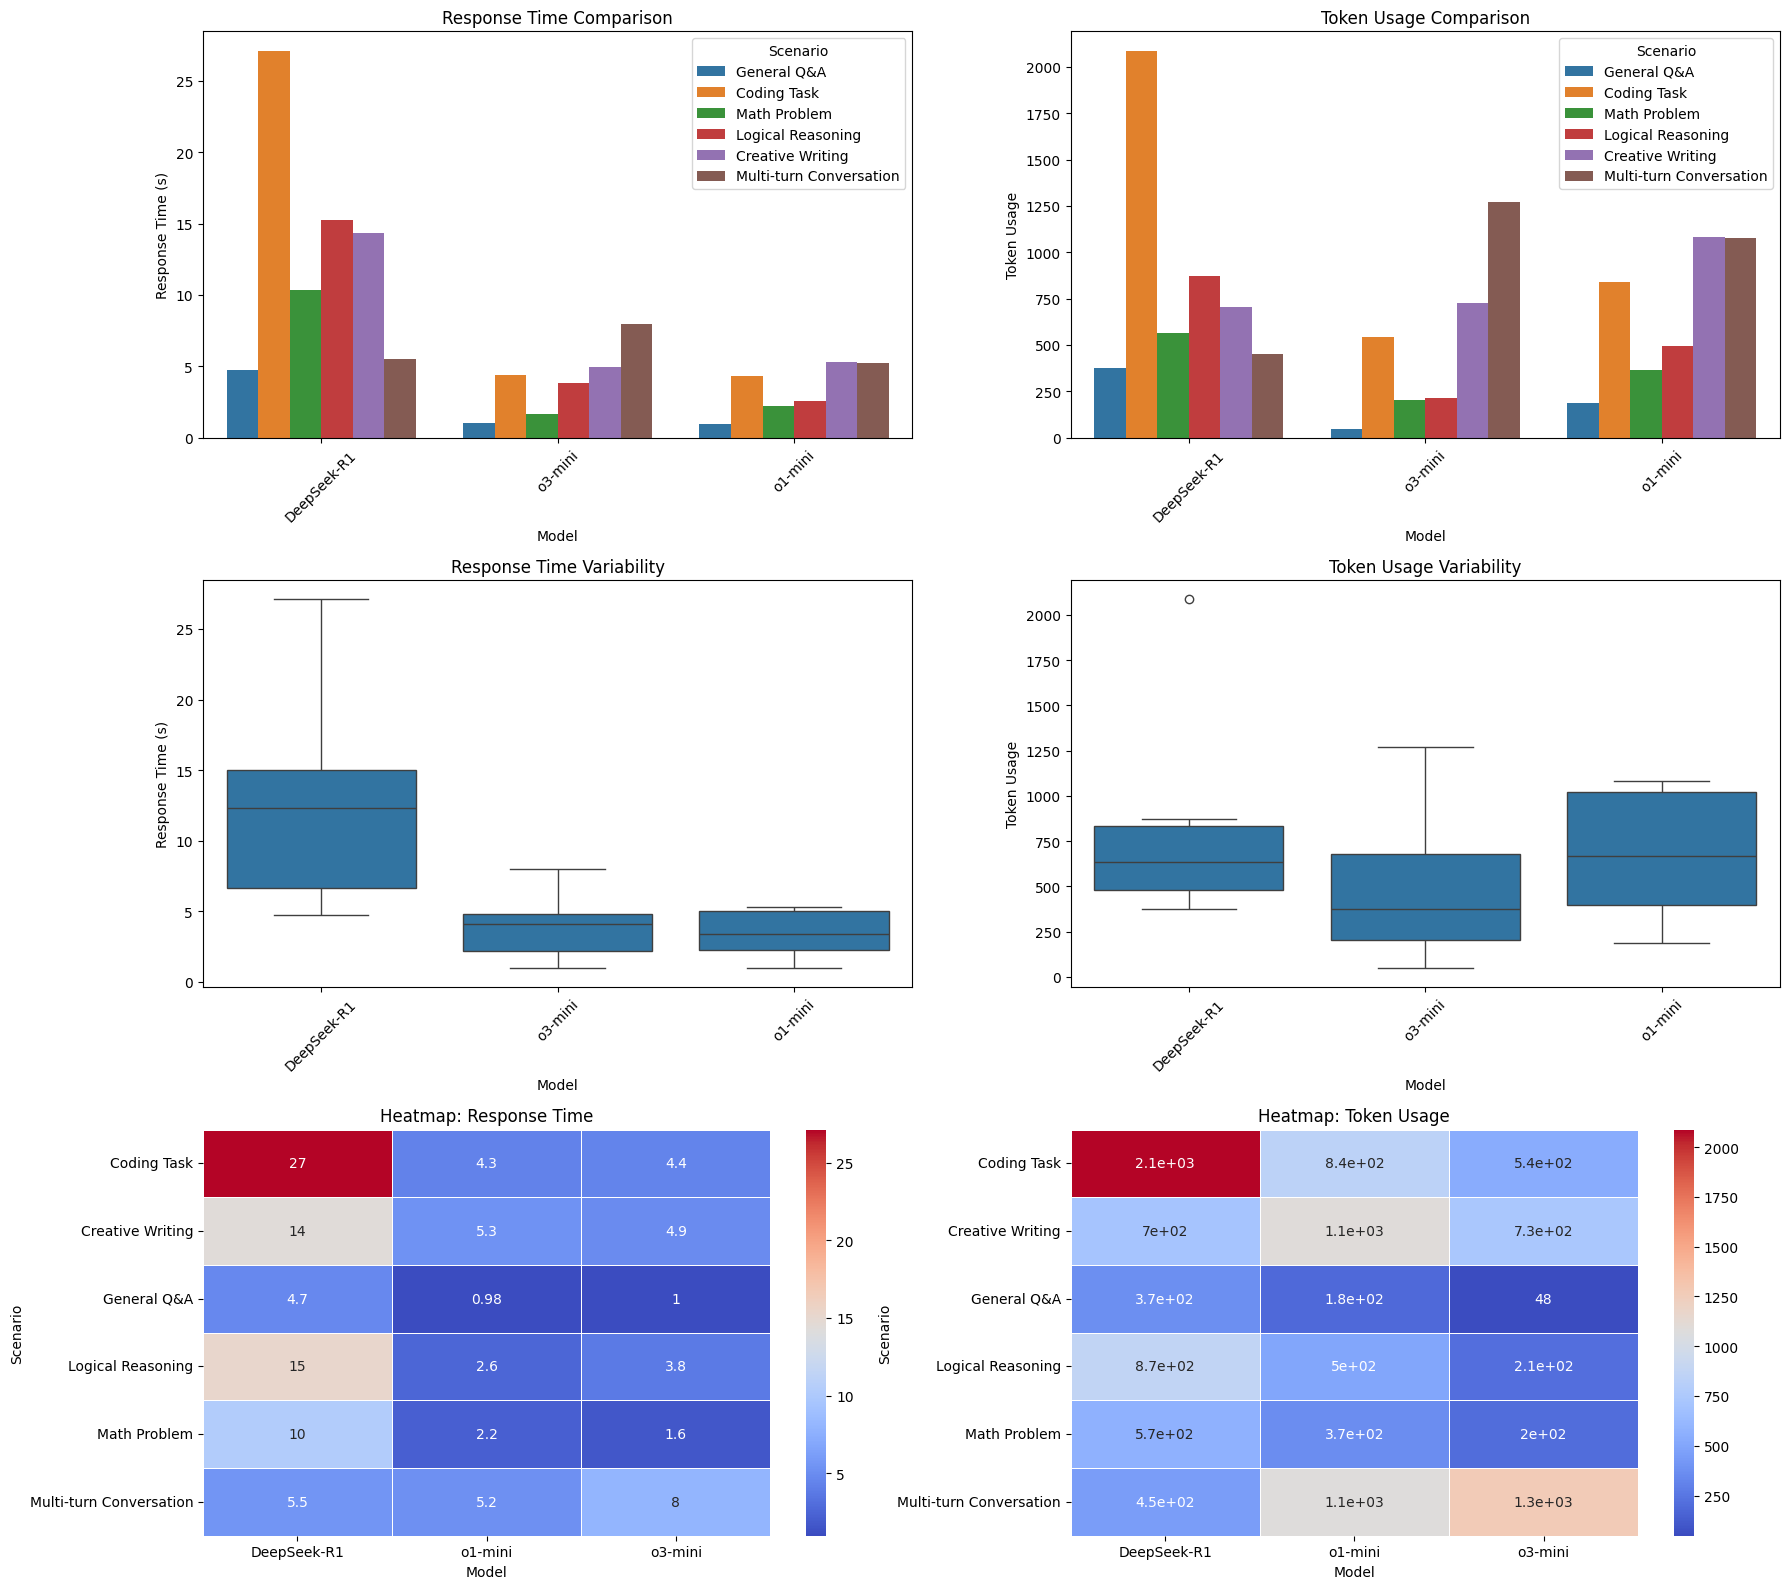

In [45]:
visualize_results(df_results)

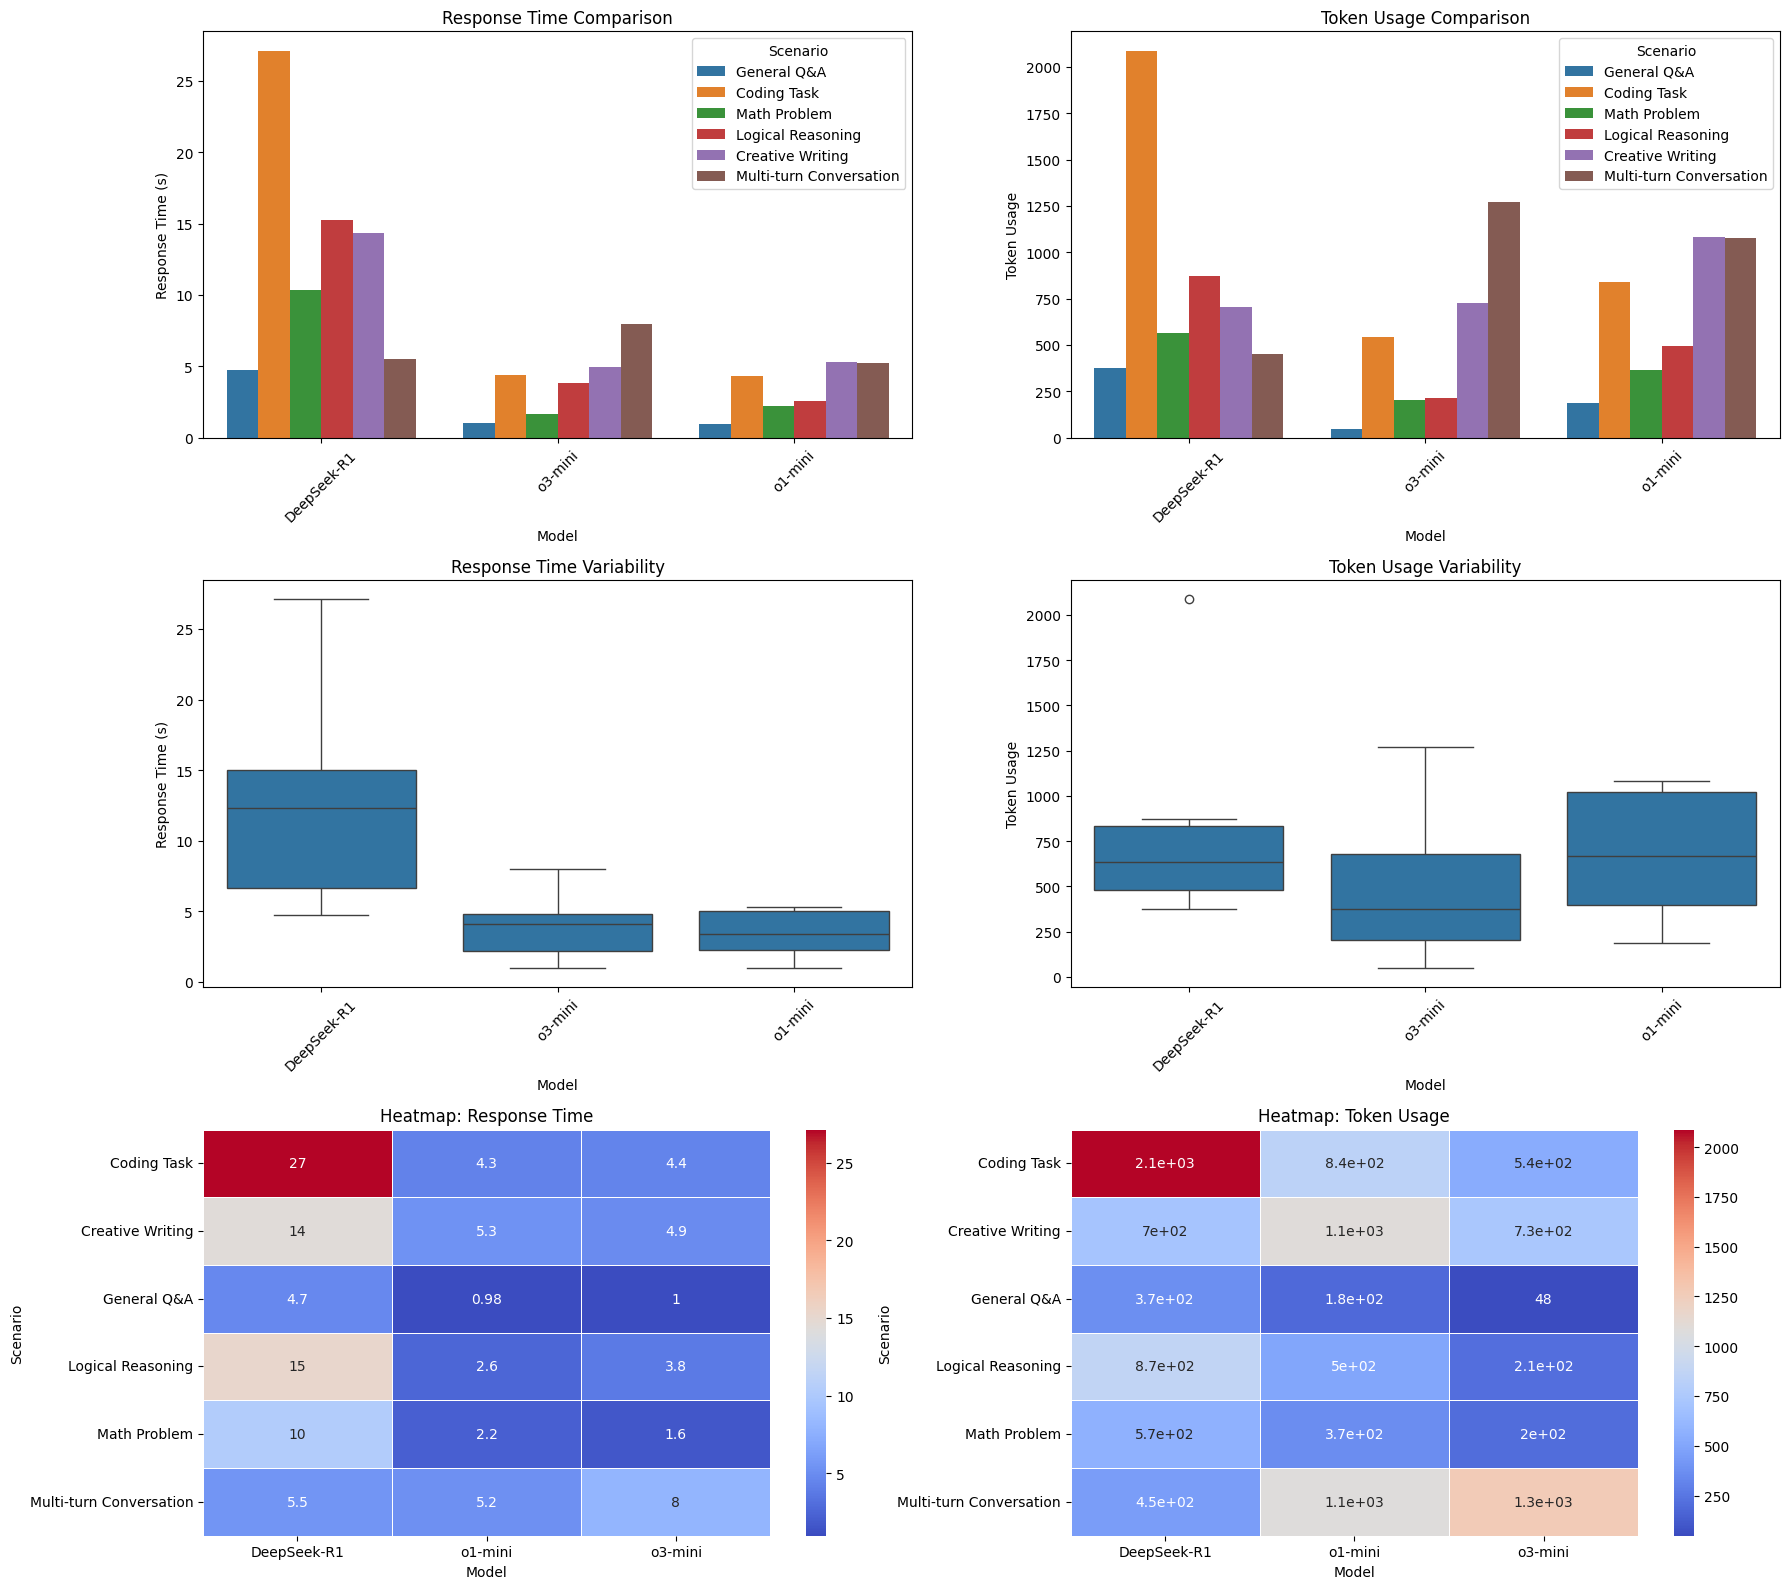